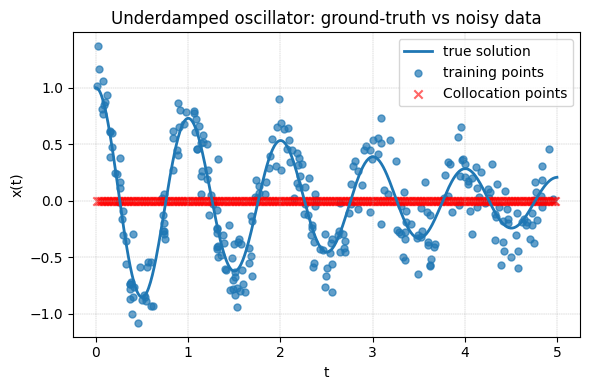

In [1]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
from torch.optim.lr_scheduler import StepLR

torch.set_num_threads(4)
seed = 12345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_damposcillation import DampedOscillator1D  

ζ      = 0.05                       # damping ratio
ω      = 2 * math.pi * 1.0          # natural frequency (1 Hz)
ω_d    = ω * math.sqrt(1 - ζ**2)    # damped natural frequency
u0, v0 = 1.0, 0.0                   # initial displacement & velocity

forcing_func  = lambda t: 0.0 * t   # zero external force

true_solution = lambda t: (
    np.exp(-ζ * ω * t) *
    (u0 * np.cos(ω_d * t) + (v0 + ζ * ω * u0) / ω_d * np.sin(ω_d * t))
)

domain = (0.0, 5.0)                 # simulate 10 s

pde = DampedOscillator1D(
    zeta=ζ, omega=ω, forcing_func=forcing_func,
    init_cond=(u0, v0), domain=domain, true_solution=true_solution
)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Training / calibration / test data
# ────────────────────────────────────────────────────────────────────────────────
x_colloc_num = 300

data_noise = 0.2
(X_train, Y_train)         = pde.data_generation(300, data_noise)
(X_test, Y_test)           = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(x_colloc_num, data_noise)


# Collocation points in (0,5)
x_collocation = torch.linspace(*domain, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > domain[0]) & (x_collocation < domain[1])].view(-1, 1)

# Dense grid for nice plotting
grid_test = torch.linspace(*domain, 800).unsqueeze(1)

# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
plot_truth_and_samples_1D(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [2]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
torch.set_num_threads(4)

# PDE
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Models
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN

# CP
from utils_uqmd.utils_uq_cp import CP

# Ensure reproducibility
import random, numpy as np, torch
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Data Noise
data_noise = 0.05

# Define PDE
pde = AllenCahn2D(lam=0.01)
domain = pde.domain
true_solution = pde.true_solution  # Now returns numpy

# Generate training and testing data of the Allen-Cahn function
(X_train, Y_train) = pde.data_generation(500, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(200, data_noise)

# Number of colocation points
colloc_pt_num = 1000

# Generating alphas to test
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]
alphas = generating_alphas(10)

# --------------------------------------------
# Build base model
# --------------------------------------------

do_pinn = DropoutPINN(
    pde_class=pde, 
    input_dim=2,
    hidden_dims=[32, 64, 128, 128, 64, 32], 
    output_dim=1, 
    p_drop=0.1
)

# --------------------------------------------
# Define tuning arguments
# --------------------------------------------

fit_args = {
    "coloc_pt_num": colloc_pt_num,
    "X_train": X_train, 
    "Y_train": Y_train
}
fit_kwargs_grid = {
    "epochs": [20000, 30000, 40000],
    "λ_pde": [3.0, 5.0], "λ_bc": [5.0, 10.0], "λ_data": [1.0, 2.0, 5.0],
    "lr": [1e-3, 3e-4],
    "stop_schedule": [10000, 20000, 40000]
}

baseline_pred_kwargs = { "n_samples": 100 }

cp_pred_kwargs = {
        "X_train": X_train,  "Y_train": Y_train,
        "X_cal": X_calibration, "Y_cal": Y_calibration,
        "heuristic_u": "raw_std",
        "k": 10
}

cp_coverage_args = {
    "alphas": alphas, 
    "X_test": X_test, "Y_test": Y_test, 
    "X_cal": X_calibration, "Y_cal": Y_calibration, "X_train": X_train, "Y_train": Y_train, 
    "heuristic_u": "raw_std",
    "k": 1
}

baseline_coverage_args = { 
    "uqmodel": do_pinn,
    "alphas": alphas, 
    "X_test": X_test, "Y_test": Y_test,
    "n_samples": 100
}

# --------------------------------------------
# Defining Plotting Grid
# --------------------------------------------
n_grid = 100
x = torch.linspace(domain[0][0], domain[0][1], n_grid)
y = torch.linspace(domain[1][0], domain[1][1], n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# --------------------------------------------
# Start hyperparameter tuning 
# --------------------------------------------
from utils_tools.utils_tuning import hyperparameter_tuning
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
from utils_uqmd.utils_uq_cp import CP
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties

hyperparameter_tuning(
    plot_title="Allen-Cahn 2D Dropout CP Model",
    uqmodel=do_pinn,
    alpha=0.05, 
    X_test=grid_test, Y_test=pde.true_solution(grid_test.numpy()),  # Make sure true_solution returns numpy
    fit_args=fit_args, fit_kwargs_grid=fit_kwargs_grid, baseline_pred_kwargs=baseline_pred_kwargs, cp_pred_kwargs=cp_pred_kwargs, 
    true_solution=pde.true_solution,
    baseline_coverage_args=baseline_coverage_args, cp_coverage_args=cp_coverage_args,
    baseline_test_uncertainties=do_test_uncertainties,
    plotting_func=plot_2D_comparison_with_coverage,
    save_dir="allencahn2d_do_cp"
)


Using device: cpu
Using device: cpu

[🔎] Trying: {'epochs': 20000, 'λ_pde': 3.0, 'λ_bc': 5.0, 'λ_data': 1.0, 'lr': 0.001, 'stop_schedule': 10000}

[🟠] Training...


AttributeError: 'int' object has no attribute 'requires_grad_'